In [1]:
import warnings
warnings.filterwarnings('ignore')

### Data Preparation for Apriori Algorithm

According to the requirements, **each disease represents a "basket"** and the "items" in this basket are the symptoms that appear for that disease.

**Data Preparation Strategy:**
- We group all cases of the same disease together
- Each disease becomes a transaction (basket) containing all unique symptoms that appear for that disease across all cases
- This approach identifies symptom combinations that frequently co-occur within the same disease profile

**Data Cleaning and Normalization:**
- Normalize symptom synonyms (e.g., "fever" vs "pyrexia", "vomit" vs "vomiting")
- Remove extra spaces and underscores
- Validate minimum number of transactions to ensure robust frequent itemsets


# Task 1: Symptom Co-occurrence Analysis

## Objective
The goal of this task is to analyse the co-occurrence patterns of different symptoms within disease profiles. Specifically, the task aims to identify combinations of symptoms that frequently appear together in the same disease.

## Method
Implement the Apriori algorithm to analyse the Disease Symptom dataset, identifying common combinations of symptoms that frequently co-occur within the same disease profile.


## 1. Setup and Environment
Helper functions are created in the src folder to process our datasets and mine patterns in our data. Below are the 2 files used to implement these functions:

- SymptomDataProcessor
    - Contains functions to clean and create "baskets" for each transaction

- SymptomPatternMiner
    - Contains functions to encode the items and perform pattern mining

In [2]:
import sys
from pathlib import Path
import numpy as np
from collections import Counter
import ast
import importlib

# Add project root to Python path to import custom modules
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))

from src.processors.symptom_data_processor import SymptomDataProcessor
from src.analysis.symptom_pattern_miner import SymptomPatternMiner

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

print("Libraries and modules imported successfully.")

Libraries and modules imported successfully.


## 2. Data Loading and Preprocessing
First we load the dataset for **Disease Symptom**, which contains information linking diseases to their associated symptoms

Data Columns:
* *Disease:* Name of the disease
* *Symptom_1* to *Symptom_17*: Various symptoms associated with each disease

We also have additional files containing *symptom descriptions*, *precautions* and *severity weights*



### Data Preprocessing

**Data Preparation:** We start by grouping the symptoms into "baskets", so each disease has a list of symptoms that appear with it

**Data Cleaning:** To avoid redundancy, we have normalized the names of the symptoms and removed any spaces or underscores

In [3]:
# Define the path to the dataset using the project_root variable
# This ensures the path is always correct, regardless of where the notebook is run
DATA_PATH = project_root / 'data' / 'dataset.csv'

# Initialize and run the data processor
processor = SymptomDataProcessor(data_path=DATA_PATH)
transactions = processor.process_data(group_by_disease=True, min_transactions=10)

# Create a mapping of disease names to transactions
# We need to reload the data to get disease names
df_raw = pd.read_csv(DATA_PATH)
disease_symptoms = {}
for index, row in df_raw.iterrows():
    disease = row['Disease'] if pd.notna(row['Disease']) else None
    if disease:
        symptom_cols = [col for col in df_raw.columns if 'Symptom' in col]
        if disease not in disease_symptoms:
            disease_symptoms[disease] = set()
        for col in symptom_cols:
            symptom = processor._clean_symptom(row[col])
            if symptom:
                normalized_symptom = processor._normalize_symptom(symptom)
                disease_symptoms[disease].add(normalized_symptom)

# Create disease-to-transaction mapping
disease_names = list(disease_symptoms.keys())
disease_to_transaction = {disease: list(symptoms) for disease, symptoms in disease_symptoms.items()}

# Verify mapping matches transactions
assert len(transactions) == len(disease_names), "Mismatch between transactions and disease names"

print(f"\nSuccessfully processed {len(transactions)} transactions (disease baskets).")
print(f"Example disease: {disease_names[0]}")
print(f"Example transaction (disease basket): {transactions[0]}")

# Display statistics about the data
total_symptoms = sum(len(t) for t in transactions)
avg_symptoms_per_disease = total_symptoms / len(transactions)
print(f"\nData Statistics:")
print(f"  Total diseases: {len(transactions)}")
print(f"  Total symptoms across all diseases: {total_symptoms}")
print(f"  Average symptoms per disease: {avg_symptoms_per_disease:.2f}")


Processing symptoms: 100%|██████████| 4920/4920 [00:00<00:00, 37299.82it/s]



Successfully processed 41 transactions (disease baskets).
Example disease: Fungal infection
Example transaction (disease basket): ['dischromic patches', 'itching', 'nodal skin eruptions', 'skin rash']

Data Statistics:
  Total diseases: 41
  Total symptoms across all diseases: 297
  Average symptoms per disease: 7.24


## 3. Apriori Algorithm and Association Rule Mining
We will be using the implementation of `apriori` from `mlxtend` to mine the frequent itemsets in our dataset
- A `min_support` of 0.03 is used to generate the frequent itemsets 
- As the dataset is not too large, a support of 0.03 allows us to capture more itemsets while still filtering out those that have insufficient support

From here, we can then generate some association rules
- With the generated rules, we can analyse the different patterns of symptoms associated with different diseases

In [4]:
# Set a minimum support level of 3%
miner = SymptomPatternMiner(transactions, min_support=0.03)

# Mine for frequent itemsets
frequent_itemsets = miner.mine_frequent_itemsets()

print(f"\nFound {len(frequent_itemsets)} frequent itemsets.")
print(f"Itemset sizes range from 1 to {frequent_itemsets['itemsets'].apply(len).max()}")

# Generate association rules with a minimum confidence of 50%
rules = miner.generate_association_rules(metric="confidence", min_threshold=0.5)
print(f"Generated {len(rules)} association rules with confidence >= 0.5")

# Save Results to CSV
# This allows the analysis section to load pre-computed results,
# either from this run or from a previous run of the `symptom_analysis.py` script.
output_dir = project_root / 'outputs'
output_dir.mkdir(exist_ok=True) # Ensure the directory exists

# Save as pickle to preserve the data structure
itemsets_path = output_dir / 'frequent_itemsets.pkl'
rules_path = output_dir / 'association_rules.pkl'

frequent_itemsets.to_pickle(itemsets_path)
rules.to_pickle(rules_path)

print("Frequent itemsets and association rules have been saved to the 'outputs' directory.")
print(f"Itemsets saved to: {itemsets_path}")
print(f"Rules saved to: {rules_path}")


Found 928 frequent itemsets.
Itemset sizes range from 1 to 8
Generated 12269 association rules with confidence >= 0.5
Frequent itemsets and association rules have been saved to the 'outputs' directory.
Itemsets saved to: /Users/chengyao/Documents/GitHub/SC4020-Group-Project-2/outputs/frequent_itemsets.pkl
Rules saved to: /Users/chengyao/Documents/GitHub/SC4020-Group-Project-2/outputs/association_rules.pkl


## 4. Load and Analyse Results

The pre-computed results from the `outputs` directory will be loaded to avoid rerunning the itemsets and rules generation. 

These files can be generated by running the cell above, or by running the main analysis script: `python scripts/symptom_analysis.py`.

This separates the time-consuming mining process from the interactive analysis and visualization.

In [5]:
# Load the frequent itemsets and association rules from the pickle files saved in the 'outputs' directory.
itemsets_path = project_root / 'outputs' / 'frequent_itemsets.pkl'
rules_path = project_root / 'outputs' / 'association_rules.pkl'

saved_frequent_itemsets = pd.read_pickle(itemsets_path)
saved_rules = pd.read_pickle(rules_path)

print("Successfully loaded pre-computed results from pickle files.")

Successfully loaded pre-computed results from pickle files.


### Analysing Frequent Itemsets
After getting the list of frequent itemsets, we can take a look at the distribution of the number of symptoms in each of the itemsets to get a good sensing of the number of symptoms in our itemsets


FREQUENT ITEMSETS ANALYSIS

Itemset size distribution:
  Size 1: 48 itemsets
  Size 2: 159 itemsets
  Size 3: 254 itemsets
  Size 4: 236 itemsets
  Size 5: 148 itemsets
  Size 6: 64 itemsets
  Size 7: 17 itemsets
  Size 8: 2 itemsets


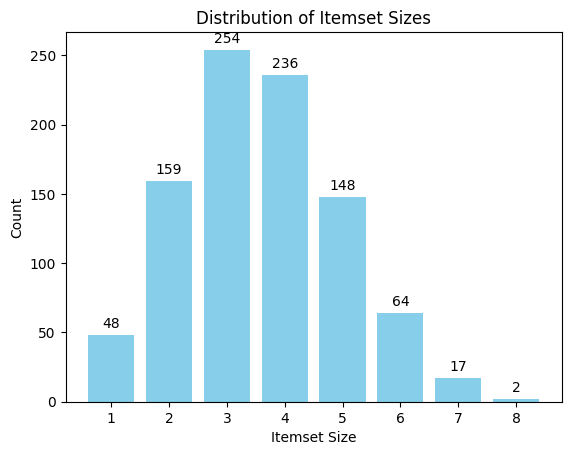

In [6]:
# Analyse frequent itemsets by size
print("\n" + "="*60)
print("FREQUENT ITEMSETS ANALYSIS")
print("="*60)

# Group by itemset size
saved_frequent_itemsets['itemset_size'] = saved_frequent_itemsets['itemsets'].apply(len)
size_counts = saved_frequent_itemsets.groupby('itemset_size').size()
print(f"\nItemset size distribution:")
for size, count in size_counts.items():
    print(f"  Size {size}: {count} itemsets")

bars = plt.bar(size_counts.index, size_counts.values, color='skyblue')
plt.xticks(size_counts.index)
plt.bar_label(bars, padding=3)
plt.xlabel('Itemset Size')
plt.ylabel('Count')
plt.title('Distribution of Itemset Sizes')
plt.show()


From the bar plot, we can see that the **most common itemset size** is **3**, and the distribution appears to be fairly uniform, with a slight right skew (due to the 2 itemsets with 8 elements forming a longer right tail)

## Analysis of results

After the general overview, we can dive deeper to extract more information from the itemsets.

We will load the **Top 10 Most Frequent Itemsets**, along with the **Top 10 Most Cofident Association Rules**. An explanation of the association rules and the terms involved will be provided below the cell output.

### Top 10 Most Frequent Single Symptoms

In [7]:
print(f"\nTop 10 Most Frequent Single Symptoms:")
single_symptoms = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] == 1].nlargest(10, 'support')
for idx, row in single_symptoms.iterrows():
    symptom = list(row['itemsets'])[0]
    print(f"  {symptom}: {row['support']:.4f} ({row['support']*100:.2f}% of diseases)")


Top 10 Most Frequent Single Symptoms:
  vomiting: 0.4390 (43.90% of diseases)
  fatigue: 0.4146 (41.46% of diseases)
  high fever: 0.2927 (29.27% of diseases)
  abdominal pain: 0.2683 (26.83% of diseases)
  headache: 0.2439 (24.39% of diseases)
  loss of appetite: 0.2439 (24.39% of diseases)
  yellowish skin: 0.1951 (19.51% of diseases)
  chills: 0.1707 (17.07% of diseases)
  itching: 0.1707 (17.07% of diseases)
  skin rash: 0.1707 (17.07% of diseases)


### Top 10 Most Frequent Symptom Combinations (size = 3)

In [8]:
print(f"\nTop 10 Most Frequent Symptom Combinations (size = 3):")
multi_symptoms = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] == 3].nlargest(10, 'support')
for idx, row in multi_symptoms.iterrows():
    symptoms = ', '.join(list(row['itemsets']))
    print(f"  {{{symptoms}}}: {row['support']:.4f} ({row['support']*100:.2f}% of diseases)")



Top 10 Most Frequent Symptom Combinations (size = 3):
  {abdominal pain, yellowish skin, vomiting}: 0.1463 (14.63% of diseases)
  {loss of appetite, yellowing of eyes, vomiting}: 0.1463 (14.63% of diseases)
  {loss of appetite, yellowish skin, yellowing of eyes}: 0.1463 (14.63% of diseases)
  {dark urine, abdominal pain, yellowish skin}: 0.1220 (12.20% of diseases)
  {abdominal pain, loss of appetite, vomiting}: 0.1220 (12.20% of diseases)
  {abdominal pain, loss of appetite, yellowing of eyes}: 0.1220 (12.20% of diseases)
  {abdominal pain, loss of appetite, yellowish skin}: 0.1220 (12.20% of diseases)
  {abdominal pain, yellowish skin, yellowing of eyes}: 0.1220 (12.20% of diseases)
  {chills, high fever, fatigue}: 0.1220 (12.20% of diseases)
  {high fever, vomiting, fatigue}: 0.1220 (12.20% of diseases)


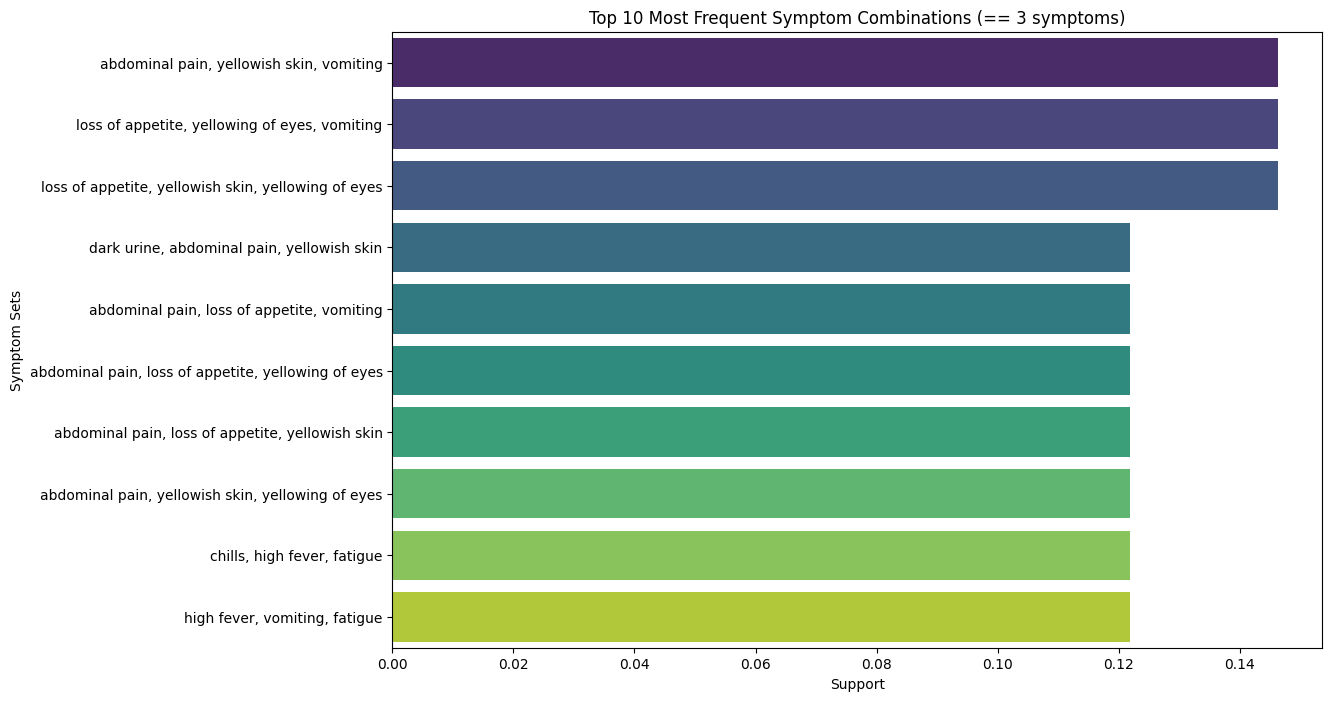


Top 10 Most Frequent Symptom Combinations ({Symptoms Combination}:support):
1. {abdominal pain, yellowish skin, vomiting}: 0.1463 (14.63% of diseases)
2. {loss of appetite, yellowing of eyes, vomiting}: 0.1463 (14.63% of diseases)
3. {loss of appetite, yellowish skin, yellowing of eyes}: 0.1463 (14.63% of diseases)
4. {dark urine, abdominal pain, yellowish skin}: 0.1220 (12.20% of diseases)
5. {abdominal pain, loss of appetite, vomiting}: 0.1220 (12.20% of diseases)
6. {abdominal pain, loss of appetite, yellowing of eyes}: 0.1220 (12.20% of diseases)
7. {abdominal pain, loss of appetite, yellowish skin}: 0.1220 (12.20% of diseases)
8. {abdominal pain, yellowish skin, yellowing of eyes}: 0.1220 (12.20% of diseases)
9. {chills, high fever, fatigue}: 0.1220 (12.20% of diseases)
10. {high fever, vomiting, fatigue}: 0.1220 (12.20% of diseases)


In [9]:
# Plot Top 10 Most Frequent Symptom Combinations (size == 3)
top_itemsets = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] == 3].nlargest(10, 'support').copy()
top_itemsets['itemsets_str'] = top_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

plt.figure(figsize=(12, 8))
sns.barplot(x='support', y='itemsets_str', data=top_itemsets, palette='viridis')
plt.title('Top 10 Most Frequent Symptom Combinations (== 3 symptoms)')
plt.xlabel('Support')
plt.ylabel('Symptom Sets')
plt.show()

print("\nTop 10 Most Frequent Symptom Combinations ({Symptoms Combination}:support):")
for i, (idx, row) in enumerate(top_itemsets.iterrows(), 1):
    symptoms = row['itemsets_str']
    print(f"{i}. {{{symptoms}}}: {row['support']:.4f} ({row['support']*100:.2f}% of diseases)")


### Association Rules
### Top 10 Rules by confidence

In [10]:
print(f"\nTotal rules generated: {len(saved_rules)}")
print(f"\nTop 10 Rules by Confidence:")
top_conf = saved_rules.nlargest(10, 'confidence')
for idx, row in top_conf.iterrows():
    ante = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    print(f"  IF {{{ante}}} THEN {{{cons}}}")
    print(f"     Confidence: {row['confidence']:.4f}, Lift: {row['lift']:.4f}, Support: {row['support']:.4f}")



Total rules generated: 12269

Top 10 Rules by Confidence:
  IF {dark urine} THEN {abdominal pain}
     Confidence: 1.0000, Lift: 3.7273, Support: 0.1220
  IF {abnormal menstruation} THEN {fatigue}
     Confidence: 1.0000, Lift: 2.4118, Support: 0.0488
  IF {abnormal menstruation} THEN {irritability}
     Confidence: 1.0000, Lift: 10.2500, Support: 0.0488
  IF {abnormal menstruation} THEN {mood swings}
     Confidence: 1.0000, Lift: 20.5000, Support: 0.0488
  IF {mood swings} THEN {abnormal menstruation}
     Confidence: 1.0000, Lift: 20.5000, Support: 0.0488
  IF {blurred and distorted vision} THEN {increased appetite}
     Confidence: 1.0000, Lift: 10.2500, Support: 0.0732
  IF {phlegm} THEN {chest pain}
     Confidence: 1.0000, Lift: 6.8333, Support: 0.0732
  IF {continuous sneezing} THEN {chills}
     Confidence: 1.0000, Lift: 5.8571, Support: 0.0488
  IF {phlegm} THEN {chills}
     Confidence: 1.0000, Lift: 5.8571, Support: 0.0732
  IF {phlegm} THEN {cough}
     Confidence: 1.0000

### Top 10 Rules by Lift (strongest associations)

In [11]:
print(f"\nTop 10 Rules by Lift (strongest associations):")
top_lift = saved_rules.nlargest(10, 'lift')
for idx, row in top_lift.iterrows():
    ante = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    print(f"  IF {{{ante}}} THEN {{{cons}}}")
    print(f"     Lift: {row['lift']:.4f}, Confidence: {row['confidence']:.4f}, Support: {row['support']:.4f}")



Top 10 Rules by Lift (strongest associations):
  IF {abnormal menstruation} THEN {mood swings}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {mood swings} THEN {abnormal menstruation}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {painful walking} THEN {swelling joints}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {swelling joints} THEN {painful walking}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {abnormal menstruation, fatigue} THEN {mood swings}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {fatigue, mood swings} THEN {abnormal menstruation}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {abnormal menstruation} THEN {fatigue, mood swings}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {mood swings} THEN {abnormal menstruation, fatigue}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {mood swings, irritability} THEN {abnormal menstruation}
     Lift: 20.5000, Confid

In [12]:
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Total transactions (disease baskets): {len(transactions)}")
print(f"Total frequent itemsets: {len(saved_frequent_itemsets)}")
print(f"Total association rules: {len(saved_rules)}")
print(f"Average confidence: {saved_rules['confidence'].mean():.4f}")
print(f"Average lift: {saved_rules['lift'].mean():.4f}")
print(f"Rules with lift > 1.5 (strong positive association): {(saved_rules['lift'] > 1.5).sum()}")


SUMMARY
Total transactions (disease baskets): 41
Total frequent itemsets: 928
Total association rules: 12269
Average confidence: 0.8005
Average lift: 9.2926
Rules with lift > 1.5 (strong positive association): 12228


In [13]:
# Display top 10 itemsets and rules tables
print("\nFrequent Itemsets (Top 10):")
display(saved_frequent_itemsets.head(10))

print("\nAssociation Rules (Top 10):")
display(saved_rules.head(10))


Frequent Itemsets (Top 10):


,support,itemsets,itemset_size
0,0.268293,(abdominal pain),1
1,0.048780,(abnormal menstruation),1
2,0.048780,(acidity),1
3,0.048780,(back pain),1
4,0.073171,(blurred and distorted vision),1
5,0.097561,(breathlessness),1
6,0.146341,(chest pain),1
7,0.170732,(chills),1
8,0.048780,(constipation),1
9,0.048780,(continuous sneezing),1



Association Rules (Top 10):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(dark urine),(abdominal pain),0.121951,0.268293,0.121951,1.000000,3.727273,0.089233,inf,0.833333
1,(itching),(abdominal pain),0.170732,0.268293,0.121951,0.714286,2.662338,0.076145,2.560976,0.752941
2,(joint pain),(abdominal pain),0.146341,0.268293,0.073171,0.500000,1.863636,0.033908,1.463415,0.542857
3,(abdominal pain),(loss of appetite),0.268293,0.243902,0.146341,0.545455,2.236364,0.080904,1.663415,0.755556
4,(loss of appetite),(abdominal pain),0.243902,0.268293,0.146341,0.600000,2.236364,0.080904,1.829268,0.731183
5,(abdominal pain),(vomiting),0.268293,0.439024,0.219512,0.818182,1.863636,0.101725,3.085366,0.633333
6,(vomiting),(abdominal pain),0.439024,0.268293,0.219512,0.500000,1.863636,0.101725,1.463415,0.826087
7,(yellowing of eyes),(abdominal pain),0.170732,0.268293,0.121951,0.714286,2.662338,0.076145,2.560976,0.752941
8,(abdominal pain),(yellowish skin),0.268293,0.195122,0.170732,0.636364,3.261364,0.118382,2.213415,0.947619
9,(yellowish skin),(abdominal pain),0.195122,0.268293,0.170732,0.875000,3.261364,0.118382,5.853659,0.861472


### Explanation of Association Rule Metrics
This section provides explanations for the terms used in the association rules.

For a rule **"IF {A} THEN {B}"**:

| Column | Simple Explanation | In Technical Terms |
| :--- | :--- | :--- |
| **`antecedents`** | The "IF" part of the rule. This is symptom set {A}. | `antecedents` |
| **`consequents`** | The "THEN" part of the rule. This is symptom set {B}. | `consequents` |
| **`antecedent support`** | How often symptom {A} appears in the entire dataset. | `support(A)` |
| **`consequent support`** | How often symptom {B} appears in the entire dataset. | `support(B)` |
| **`support`** | How often {A} and {B} appear **together** in the dataset. | `support(A U B)` |
| **`confidence`** | **The rule's reliability.** "If a patient has {A}, what's the probability they also have {B}?" Higher is better. | `support(A U B) / support(A)` |
| **`lift`** | **The rule's importance.** How much more likely {B} is to appear when {A} is present. `> 1` is good. Higher is better. | `confidence(A->B) / support(B)` |
| **`leverage`** | The difference between how often {A} and {B} appear together versus how often they would if they were independent. `> 0` means they appear together more than expected. | `support(A U B) - (support(A) * support(B))` |
| **`conviction`** | A measure of the rule's implication. A high value means the consequent {B} is highly dependent on the antecedent {A}. An `inf` (infinity) value is very strong. | `(1 - support(B)) / (1 - confidence(A->B))` |
| **`zhangs_metric`** | A more advanced measure of association that ranges from -1 (perfect negative correlation) to +1 (perfect positive correlation). 0 indicates independence. | A value that considers both support and confidence. |
| **`kulczynski`** | The average of the two confidence scores (`A->B` and `B->A`). It's a symmetric measure of how strongly the two are related. | `0.5 * (confidence(A->B) + confidence(B->A))` |


## 5. Disease-Level Analysis

We can map the frequent symptom combinations back to the specific diseases they appear in to allow us to see how symptom patterns co-occur within disease profiles.


### 5.1 Mapping Frequent Itemsets to Diseases

We analyse which diseases contain the most frequent symptom combinations, providing explicit evidence of symptom co-occurrence within disease profiles.


In [14]:
# Function to find which diseases contain a given itemset
def find_diseases_with_itemset(itemset, disease_to_transaction):
    """
    Find all diseases that contain all symptoms in the given itemset.
    
    Args:
        itemset: A set or list of symptoms
        disease_to_transaction: Dictionary mapping disease names to their symptom lists
        
    Returns:
        List of disease names that contain all symptoms in the itemset
    """
    itemset_set = set(itemset) if isinstance(itemset, (list, frozenset)) else itemset
    matching_diseases = []
    for disease, symptoms in disease_to_transaction.items():
        symptom_set = set(symptoms)
        if itemset_set.issubset(symptom_set):
            matching_diseases.append(disease)
    return matching_diseases

# Analyse top frequent itemsets and map them to diseases
print("="*60)
print("DISEASE-LEVEL ANALYSIS: Mapping Frequent Itemsets to Diseases")
print("="*60)

# Analyse top 10 most frequent symptom combinations (size == 3)
top_itemsets = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] == 3].nlargest(10, 'support').copy()

print("\nTop 10 Most Frequent Symptom Combinations and Their Associated Diseases:")
print("-" * 60)

for idx, row in top_itemsets.iterrows():
    itemset = row['itemsets']
    support = row['support']
    diseases = find_diseases_with_itemset(itemset, disease_to_transaction)
    
    symptoms_str = ', '.join(list(itemset))
    num_diseases = len(diseases)
    support_pct = support * 100
    
    print(f"\nItemset: {{{symptoms_str}}}")
    print(f"  Support: {support:.4f} ({support_pct:.2f}% of diseases)")
    print(f"  Appears in {num_diseases} disease(s): {', '.join(diseases)}")


DISEASE-LEVEL ANALYSIS: Mapping Frequent Itemsets to Diseases

Top 10 Most Frequent Symptom Combinations and Their Associated Diseases:
------------------------------------------------------------

Itemset: {abdominal pain, yellowish skin, vomiting}
  Support: 0.1463 (14.63% of diseases)
  Appears in 6 disease(s): Chronic cholestasis, Jaundice, hepatitis A, Hepatitis D, Hepatitis E, Alcoholic hepatitis

Itemset: {loss of appetite, yellowing of eyes, vomiting}
  Support: 0.1463 (14.63% of diseases)
  Appears in 6 disease(s): Chronic cholestasis, hepatitis A, Hepatitis C, Hepatitis D, Hepatitis E, Tuberculosis

Itemset: {loss of appetite, yellowish skin, yellowing of eyes}
  Support: 0.1463 (14.63% of diseases)
  Appears in 6 disease(s): Chronic cholestasis, hepatitis A, Hepatitis B, Hepatitis C, Hepatitis D, Hepatitis E

Itemset: {dark urine, abdominal pain, yellowish skin}
  Support: 0.1220 (12.20% of diseases)
  Appears in 5 disease(s): Jaundice, hepatitis A, Hepatitis B, Hepatitis D,

### 5.2 Diseases with Most Common Symptom Patterns

We identify which diseases exhibit the most frequent symptom combinations, showing how different diseases share common symptom profiles.


In [15]:
# Count how many top frequent itemsets each disease contains
disease_itemset_counts = {disease: 0 for disease in disease_names}
disease_itemset_details = {disease: [] for disease in disease_names}

top_itemsets_list = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] == 3].nlargest(20, 'support')

for idx, row in top_itemsets_list.iterrows():
    itemset = row['itemsets']
    support = row['support']
    diseases = find_diseases_with_itemset(itemset, disease_to_transaction)
    
    for disease in diseases:
        disease_itemset_counts[disease] += 1
        disease_itemset_details[disease].append({
            'itemset': list(itemset),
            'support': support
        })

# Sort diseases by number of frequent itemsets (top 20) they contain
sorted_diseases = sorted(disease_itemset_counts.items(), key=lambda x: x[1], reverse=True)

print("\n" + "="*60)
print("DISEASES WITH MOST FREQUENT SYMPTOM PATTERNS")
print("="*60)
print("\nTop 10 diseases containing the most frequent symptom combinations:")
print("-" * 60)

for i, (disease, count) in enumerate(sorted_diseases[:10], 1):
    print(f"\n{i}. {disease}")
    print(f"   Contains {count} of the top 20 frequent symptom combinations")
    print(f"   Number of symptoms: {len(disease_to_transaction[disease])}")
    
    # Show top 3 itemsets for this disease
    top_for_disease = sorted(disease_itemset_details[disease], 
                             key=lambda x: x['support'], reverse=True)[:3]
    print(f"   Top symptom combinations:")
    for j, itemset_info in enumerate(top_for_disease, 1):
        itemset_str = ', '.join(itemset_info['itemset'])
        support_pct = itemset_info['support'] * 100
        print(f"      {j}. {{{itemset_str}}} (support: {itemset_info['support']:.4f}, {support_pct:.2f}% of diseases)")



DISEASES WITH MOST FREQUENT SYMPTOM PATTERNS

Top 10 diseases containing the most frequent symptom combinations:
------------------------------------------------------------

1. Hepatitis E
   Contains 19 of the top 20 frequent symptom combinations
   Number of symptoms: 12
   Top symptom combinations:
      1. {abdominal pain, yellowish skin, vomiting} (support: 0.1463, 14.63% of diseases)
      2. {loss of appetite, yellowing of eyes, vomiting} (support: 0.1463, 14.63% of diseases)
      3. {loss of appetite, yellowish skin, yellowing of eyes} (support: 0.1463, 14.63% of diseases)

2. Hepatitis D
   Contains 18 of the top 20 frequent symptom combinations
   Number of symptoms: 8
   Top symptom combinations:
      1. {abdominal pain, yellowish skin, vomiting} (support: 0.1463, 14.63% of diseases)
      2. {loss of appetite, yellowing of eyes, vomiting} (support: 0.1463, 14.63% of diseases)
      3. {loss of appetite, yellowish skin, yellowing of eyes} (support: 0.1463, 14.63% of dise

### 5.3 Disease-Symptom Co-occurrence Visualization

Visualizing which diseases share common symptom patterns helps understand symptom co-occurrence across different disease profiles.


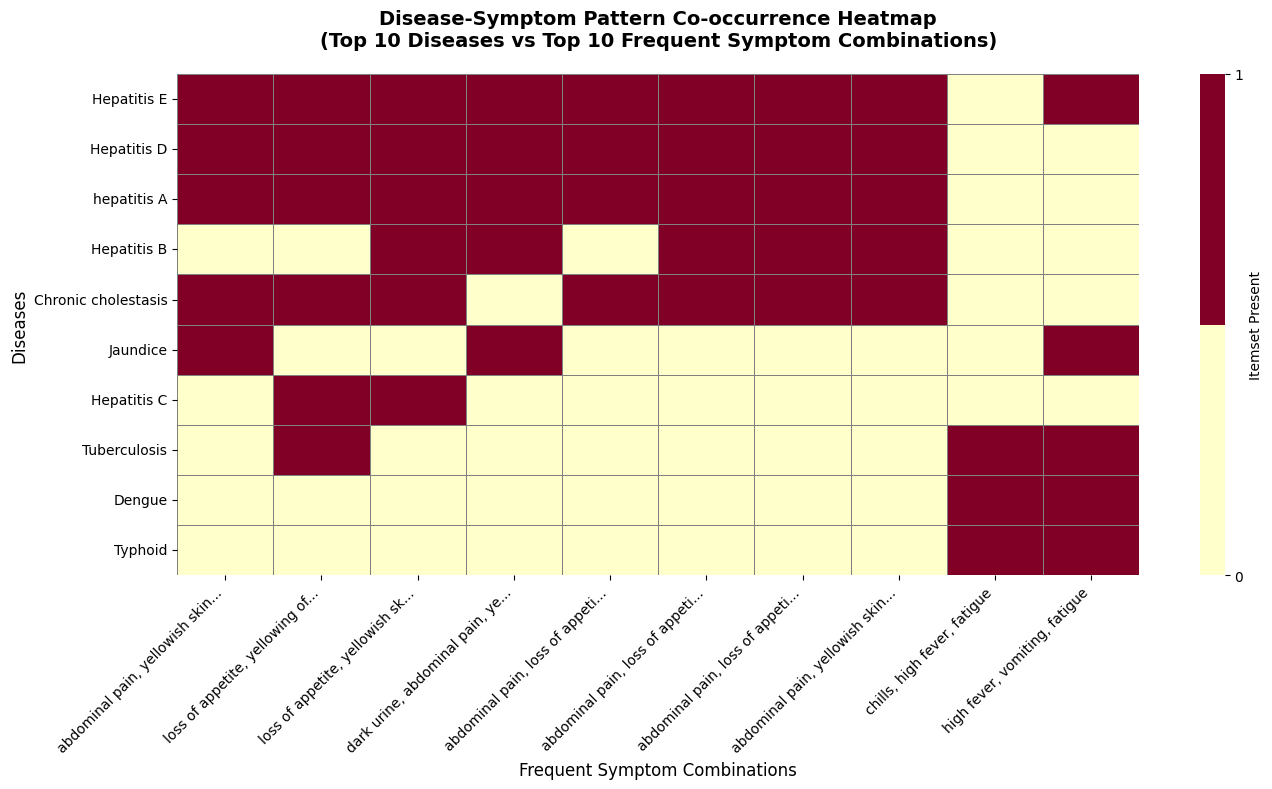


Heatmap Interpretation:
- Yellow/Red cells indicate that the disease contains all symptoms in that combination
- This visualization shows which diseases share common symptom patterns


In [16]:
# Create a heatmap showing which diseases contain top frequent itemsets
top_10_itemsets = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] == 3].nlargest(10, 'support')
top_10_diseases = [disease for disease, _ in sorted_diseases[:10]]
# top_10_diseases.sort() # Sort top 10 diseases by name for visualisation

# Create a matrix: diseases (rows) x itemsets (columns)
heatmap_data = []

for idx, row in top_10_itemsets.iterrows():
    itemset = row['itemsets']
    matching_diseases = find_diseases_with_itemset(itemset, disease_to_transaction)
    
    row_data = []
    for disease in top_10_diseases:
        row_data.append(1 if disease in matching_diseases else 0)
    heatmap_data.append(row_data)

# Transpose for better visualization (diseases as rows, itemsets as columns)
heatmap_df = pd.DataFrame(heatmap_data, 
                          index=[', '.join(list(row['itemsets']))[:30] + '...' 
                                 if len(', '.join(list(row['itemsets']))) > 30 
                                 else ', '.join(list(row['itemsets']))
                                 for _, row in top_10_itemsets.iterrows()],
                          columns=top_10_diseases)

# Create heatmap

plt.figure(figsize=(14, 8))
binary_cmap = ListedColormap(['#FFFFCC', '#800026'])
sns.heatmap(heatmap_df.T, annot=False, cmap=binary_cmap, cbar_kws={'ticks': [0, 1], 'label': 'Itemset Present'},
            linewidths=0.5, linecolor='gray')
plt.title('Disease-Symptom Pattern Co-occurrence Heatmap\n(Top 10 Diseases vs Top 10 Frequent Symptom Combinations)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Frequent Symptom Combinations', fontsize=12)
plt.ylabel('Diseases', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nHeatmap Interpretation:")
print("- Yellow/Red cells indicate that the disease contains all symptoms in that combination")
print("- This visualization shows which diseases share common symptom patterns")


## Co-occurence of symptoms in diseases
From the heatmap of the **top 10 most common diseases** (by number of itemsets), we can identify some co-occurences patterns

- **Hepatitis E** covers the largest number of frequent symptom combinations, with **9 out of the top 10** most frequent symptom sets present among its symptoms.

- The symptom sets **(vomiting, fatigue)**, **(vomiting, loss of appetite)**, and **(yellowing of eyes, loss of appetite)** appear in **7 out of the top 10** most common diseases.
    - These are 3 of the most common symptom combinations

## 6. Frequent Itemsets by Disease

Continuing from section 5 where we mapped itemsets at a disease level, we can analyses which frequent itemsets appear in each disease profile. We filter to itemsets with size == 3 and support > 0.05, then map them to their respective diseases.

For each disease, we keep only the **top 3 highest support itemsets** to focus on the most significant symptom patterns.

We will be collating a list of frequent itemsets, along with the support level and the associated disease. This will be saved in a `.pkl` file which will be used to generate features for our Machine Learning model

In [17]:
# Filter frequent itemsets: size == 3 and support > 0.05
filtered_itemsets = saved_frequent_itemsets[
    (saved_frequent_itemsets['itemset_size'] == 3) & 
    (saved_frequent_itemsets['support'] > 0.05)
].copy()

print(f"Filtered to {len(filtered_itemsets)} itemsets (size == 3, support > 0.05)")
print(f"Support range: {filtered_itemsets['support'].min():.4f} to {filtered_itemsets['support'].max():.4f}")

# Build a list of records: {itemset, support, disease}
disease_itemsets_records = []

for disease, symptoms in disease_to_transaction.items():
    disease_symptom_set = set(symptoms)
    
    # Find all filtered itemsets that are subsets of this disease's symptoms
    for idx, row in filtered_itemsets.iterrows():
        itemset = row['itemsets']
        support = row['support']
        
        # Check if itemset is a subset of disease symptoms
        if itemset.issubset(disease_symptom_set):
            disease_itemsets_records.append({
                'itemset': itemset,
                'support': support,
                'disease': disease
            })

# Create dataframe
disease_itemsets_df = pd.DataFrame(disease_itemsets_records)

print(f"\nTotal records before filtering: {len(disease_itemsets_df)}")
print(f"Unique diseases: {disease_itemsets_df['disease'].nunique()}")
print(f"Unique itemsets: {disease_itemsets_df['itemset'].nunique()}")

# Store the full count per disease for visualization (before filtering)
itemsets_per_disease_full = disease_itemsets_df.groupby('disease').size().sort_values(ascending=False)

# Keep only top 3 highest support itemsets per disease
disease_itemsets_df = disease_itemsets_df.groupby('disease', group_keys=False).apply(
    lambda x: x.nlargest(3, 'support')
).reset_index(drop=True)

print(f"\nTotal records after keeping top 3 per disease: {len(disease_itemsets_df)}")
print(f"Unique diseases with itemsets: {disease_itemsets_df['disease'].nunique()}")


# Save to pickle file
output_path = project_root / 'outputs' / 'disease_frequent_itemsets.pkl'
disease_itemsets_df.to_pickle(output_path)
print(f"\nExported to: {output_path}")

# Display sample of the data
print("\nSample data (first 10 rows):")
display(disease_itemsets_df.head(10))


Filtered to 97 itemsets (size == 3, support > 0.05)
Support range: 0.0732 to 0.1463

Total records before filtering: 344
Unique diseases: 19
Unique itemsets: 97

Total records after keeping top 3 per disease: 51
Unique diseases with itemsets: 19

Exported to: /Users/chengyao/Documents/GitHub/SC4020-Group-Project-2/outputs/disease_frequent_itemsets.pkl

Sample data (first 10 rows):


,itemset,support,disease
0,"(abdominal pain, yellowish skin, vomiting)",0.146341,Alcoholic hepatitis
1,"(cough, high fever, fatigue)",0.097561,Bronchial Asthma
2,"(cough, fatigue, breathlessness)",0.073171,Bronchial Asthma
3,"(cough, high fever, breathlessness)",0.073171,Bronchial Asthma
4,"(headache, high fever, fatigue)",0.097561,Chicken pox
5,"(loss of appetite, high fever, fatigue)",0.097561,Chicken pox
6,"(swelled lymph nodes, high fever, fatigue)",0.073171,Chicken pox
7,"(abdominal pain, yellowish skin, vomiting)",0.146341,Chronic cholestasis
8,"(loss of appetite, yellowing of eyes, vomiting)",0.146341,Chronic cholestasis
9,"(loss of appetite, yellowish skin, yellowing o...",0.146341,Chronic cholestasis


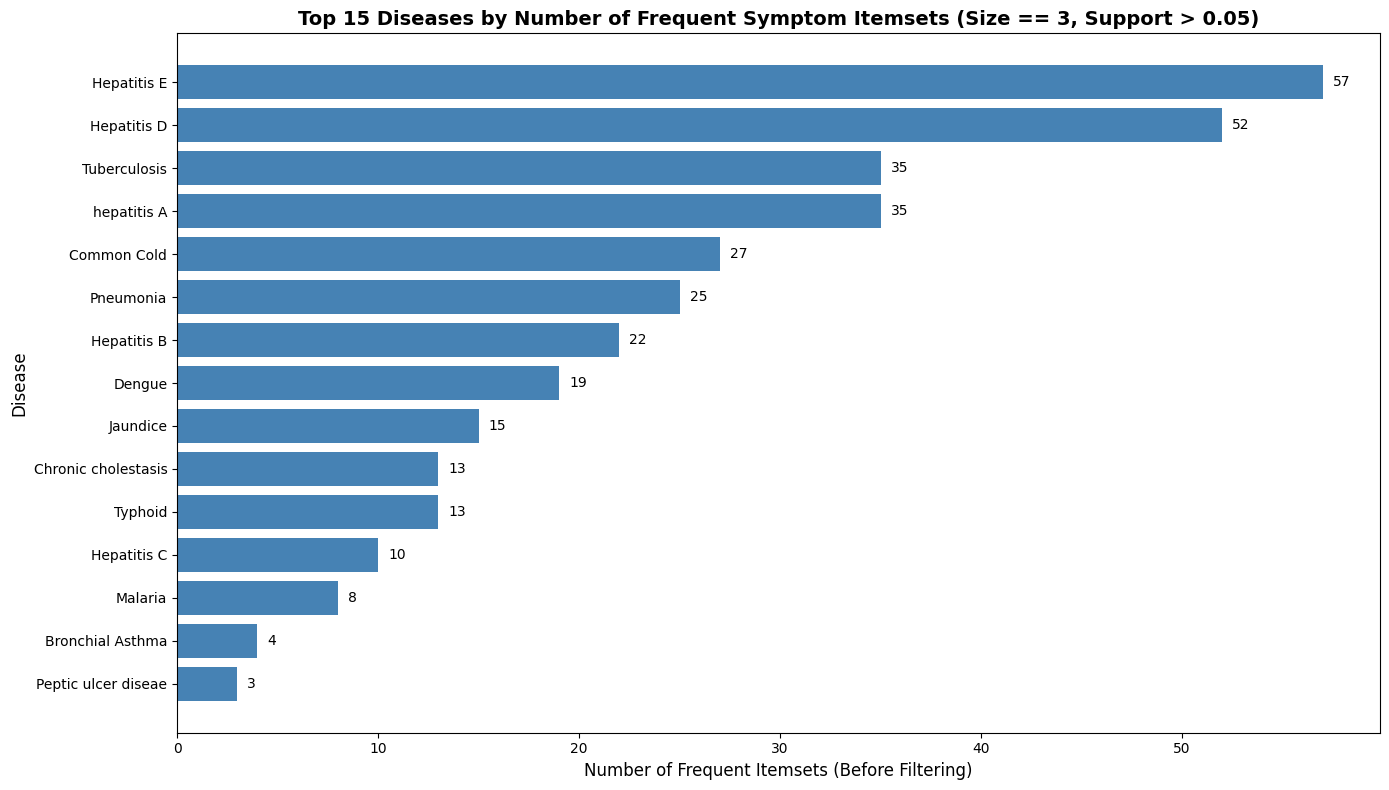


Example: Top 3 frequent itemsets for 'Hepatitis E' (exported in pkl):
  {abdominal pain, yellowish skin, vomiting} - Support: 0.1463 (14.63% of all diseases)
  {loss of appetite, yellowing of eyes, vomiting} - Support: 0.1463 (14.63% of all diseases)
  {loss of appetite, yellowish skin, yellowing of eyes} - Support: 0.1463 (14.63% of all diseases)


In [18]:
# Visualize the distribution of itemsets per disease (showing all itemsets, not just top 3)
plt.figure(figsize=(14, 8))
itemsets_per_disease_top15 = itemsets_per_disease_full.head(15)
bars = plt.barh(range(len(itemsets_per_disease_top15)), itemsets_per_disease_top15.values, color='steelblue')
plt.yticks(range(len(itemsets_per_disease_top15)), itemsets_per_disease_top15.index)
plt.xlabel('Number of Frequent Itemsets (Before Filtering)', fontsize=12)
plt.ylabel('Disease', fontsize=12)
plt.title('Top 15 Diseases by Number of Frequent Symptom Itemsets (Size == 3, Support > 0.05)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Show example itemsets for a specific disease (from the exported top 3)
example_disease = itemsets_per_disease_full.index[0]
example_itemsets = disease_itemsets_df[disease_itemsets_df['disease'] == example_disease].sort_values('support', ascending=False)

print(f"\nExample: Top {len(example_itemsets)} frequent itemsets for '{example_disease}' (exported in pkl):")
for idx, row in example_itemsets.iterrows():
    itemset_str = ', '.join(list(row['itemset']))
    print(f"  {{{itemset_str}}} - Support: {row['support']:.4f} ({row['support']*100:.2f}% of all diseases)")


# Summary of Key Findings

In [19]:
# Calculate key statistics
total_diseases = len(transactions)
top_combination = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] == 3].nlargest(1, 'support').iloc[0]
top_symptoms = ', '.join(list(top_combination['itemsets']))
top_support = top_combination['support']
top_diseases = find_diseases_with_itemset(top_combination['itemsets'], disease_to_transaction)
num_diseases_with_top = len(top_diseases)

print(f"Key Findings:")
print(f"1. Most frequent symptom combination: {{{top_symptoms}}}")
print(f"   - Appears in {top_support*100:.2f}% of all diseases ({num_diseases_with_top} out of {total_diseases} diseases)")
print(f"   - Specifically found in: {', '.join(top_diseases)}")

# Calculate average itemset support
avg_itemset_support = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] == 3]['support'].mean()
print(f"\n2. Average support for symptom combinations (size == 3): {avg_itemset_support:.4f} ({avg_itemset_support*100:.2f}% of diseases)")
print(f"   - This means symptom combinations typically appear together in {avg_itemset_support*100:.2f}% of disease profiles")

# Calculate how many diseases share common patterns
diseases_with_multiple_patterns = sum(1 for count in disease_itemset_counts.values() if count >= 5)
print(f"\n3. Pattern sharing:")
print(f"   - {diseases_with_multiple_patterns} diseases contain 5+ of the top 20 frequent symptom combinations")
print(f"   - This indicates significant symptom pattern overlap across different diseases")

print(f"\n4. Association rules:")
print(f"   - Generated {len(saved_rules)} association rules with confidence >= 50%")
print(f"   - Average confidence: {saved_rules['confidence'].mean():.4f} ({saved_rules['confidence'].mean()*100:.2f}%)")
print(f"   - Average lift: {saved_rules['lift'].mean():.4f}")
print(f"   - {((saved_rules['lift'] > 1.5).sum())} rules show strong positive associations (lift > 1.5)")

Key Findings:
1. Most frequent symptom combination: {abdominal pain, yellowish skin, vomiting}
   - Appears in 14.63% of all diseases (6 out of 41 diseases)
   - Specifically found in: Chronic cholestasis, Jaundice, hepatitis A, Hepatitis D, Hepatitis E, Alcoholic hepatitis

2. Average support for symptom combinations (size == 3): 0.0632 (6.32% of diseases)
   - This means symptom combinations typically appear together in 6.32% of disease profiles

3. Pattern sharing:
   - 8 diseases contain 5+ of the top 20 frequent symptom combinations
   - This indicates significant symptom pattern overlap across different diseases

4. Association rules:
   - Generated 12269 association rules with confidence >= 50%
   - Average confidence: 0.8005 (80.05%)
   - Average lift: 9.2926
   - 12228 rules show strong positive associations (lift > 1.5)
